# Non-tagged Retention Productivity in Article and Article Talk

This notebook is similar to 11-article-productivity-2w.ipynb, except the data it uses is only for non-tagged edits.

It makes the same cutoff for registration timestamp as 12-nontagged-article-productivity.ipynb, for the same reasons.

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
library(data.table)
library(ggplot2)

library(brms) # install.packages("brms")
library(loo) # install.packages("loo")
options(mc.cores = 4)
library(rstanarm) # install.packages("rstanarm")

Loading required package: Rcpp

Loading 'brms' package (version 2.14.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


This is loo version 2.3.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())


Attaching package: ‘rstanarm’


The following objects are masked from ‘package:brms’:

 

## Configuration variables

In [3]:
## Set BLAS threads to 1 so glmer and loo don't use all cores
library(RhpcBLASctl)
blas_set_num_threads(1)

## parallelization
options(mc.cores = 4)

### Data import and setup

In [4]:
nontagged_edit_data = fread(
    '/home/nettrom/src/Growth-homepage-2019/datasets/newcomer_tasks_nontagged_edits_nov2020.tsv',
    colClasses = c(wiki_db = 'factor'))

In [5]:
## Configuration variables for this experiment.
## Start timestamp is from https://phabricator.wikimedia.org/T227728#5680453
## End timestamp is from the data gathering notebook
start_ts = as.POSIXct('2019-11-21 00:24:32', tz = 'UTC')
end_ts = as.POSIXct('2020-04-9 00:00', tz = 'UTC')

## Start of the Variant A/B test
variant_test_ts = as.POSIXct('2019-12-13 00:32:04', tz = 'UTC')

## Convert user_registration into a timestamp
nontagged_edit_data[, user_reg_ts := as.POSIXct(user_registration_timestamp,
                                           format = '%Y-%m-%d %H:%M:%S.0', tz = 'UTC')]

## Calculate time since start of experiment in weeks
nontagged_edit_data[, exp_days := 0]
nontagged_edit_data[, exp_days := difftime(user_reg_ts, start_ts, units = 'days')]
nontagged_edit_data[exp_days < 0, exp_days := 0]
nontagged_edit_data[, ln_exp_days := log(1 + as.numeric(exp_days))]
nontagged_edit_data[, ln_exp_weeks := log(1 + as.numeric(exp_days)/7)]

## Calculate time since the start of the variant test, again in days and weeks.
## This enables us to do an interrupted time-series model for that.
nontagged_edit_data[, variant_exp_days := 0]
nontagged_edit_data[, variant_exp_days := difftime(user_reg_ts, variant_test_ts, units = 'days')]
nontagged_edit_data[variant_exp_days < 0, variant_exp_days := 0]
nontagged_edit_data[, ln_var_exp_days := log(1 + as.numeric(variant_exp_days))]
nontagged_edit_data[, ln_var_exp_weeks := log(1 + as.numeric(variant_exp_days)/7)]
nontagged_edit_data[, in_var_exp := 0]
nontagged_edit_data[user_reg_ts > variant_test_ts, in_var_exp := 1]

## Convert all NAs to 0, from
## https://stackoverflow.com/questions/7235657/fastest-way-to-replace-nas-in-a-large-data-table
na_to_zero = function(DT) {
  # or by number (slightly faster than by name) :
  for (j in seq_len(ncol(DT)))
    set(DT,which(is.na(DT[[j]])),j,0)
}

na_to_zero(nontagged_edit_data)

## Turn "reg_on_mobile" into a factor for more meaningful plots
nontagged_edit_data[, platform := 'desktop']
nontagged_edit_data[reg_on_mobile == 1, platform := 'mobile']
nontagged_edit_data[, platform := factor(platform)]

## Control variables for various forms of activation
nontagged_edit_data[, is_activated_article := num_article_edits_24hrs > 0]
nontagged_edit_data[, is_activated_other := num_other_edits_24hrs > 0]
nontagged_edit_data[, is_activated := is_activated_article | is_activated_other]

## Control variables for constructive forms of activation
nontagged_edit_data[, is_const_activated_article := (num_article_edits_24hrs - num_article_reverts_24hrs) > 0]
nontagged_edit_data[, is_const_activated_other := (num_other_edits_24hrs - num_other_reverts_24hrs) > 0]
nontagged_edit_data[, is_const_activated := is_const_activated_article | is_const_activated_other]

## Control variables for the number of edits made
nontagged_edit_data[, log_num_article_edits_24hrs := log(1 + num_article_edits_24hrs)]
nontagged_edit_data[, log_num_other_edits_24hrs := log(1 + num_other_edits_24hrs)]
nontagged_edit_data[, log_num_edits_24hrs := log(1 + num_article_edits_24hrs + num_other_edits_24hrs)]

## Control variables for the constructive number of edits made
nontagged_edit_data[, log_num_const_article_edits_24hrs := log(
    1 + num_article_edits_24hrs - num_article_reverts_24hrs)]
nontagged_edit_data[, log_num_const_other_edits_24hrs := log(
    1 + num_other_edits_24hrs - num_other_reverts_24hrs)]
nontagged_edit_data[, log_num_const_edits_24hrs := log(
    1 + num_article_edits_24hrs + num_other_edits_24hrs -
    num_article_reverts_24hrs - num_other_reverts_24hrs)]

## Retention variables
nontagged_edit_data[, is_const_retained_article := is_activated_article &
               ((num_article_edits_2w - num_article_reverts_2w) > 0)]
nontagged_edit_data[, is_const_retained_other := is_const_activated_other &
               ((num_other_edits_2w - num_other_reverts_2w) > 0)]
nontagged_edit_data[, is_const_retained := is_const_activated &
               ((num_article_edits_2w + num_other_edits_2w -
                 num_article_reverts_2w - num_other_reverts_2w) > 0)]

## Variables for number of edits (overall and only constructive)
## across the entire period.
nontagged_edit_data[, num_total_edits_24hrs := num_article_edits_24hrs + num_other_edits_24hrs]
nontagged_edit_data[, num_total_edits_2w := num_article_edits_2w + num_other_edits_2w]
nontagged_edit_data[, num_total_edits := num_total_edits_24hrs + num_total_edits_2w]

nontagged_edit_data[, num_total_const_edits_24hrs := (num_article_edits_24hrs + num_other_edits_24hrs -
                                                 num_article_reverts_24hrs - num_other_reverts_24hrs)]
nontagged_edit_data[, num_total_const_edits_2w := (num_article_edits_2w + num_other_edits_2w -
                                              num_article_reverts_2w - num_other_reverts_2w)]
nontagged_edit_data[, num_total_const_edits := num_total_const_edits_24hrs + num_total_const_edits_2w]

## Variables for number of article edits across the entire period.
nontagged_edit_data[, num_total_article_edits := num_article_edits_24hrs + num_article_edits_2w]

## Retention variables
nontagged_edit_data[, is_retained_article := is_activated_article & (num_article_edits_2w > 0)]
nontagged_edit_data[, is_retained_other := is_activated_other & (num_other_edits_2w > 0)]
nontagged_edit_data[, is_retained := is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0)]


In [6]:
## Registration cutoff (see notes above)
reg_cutoff = as.POSIXct('2019-12-13 09:00:00', tz = 'UTC')

eligible_user_edit_data = nontagged_edit_data[user_reg_ts > reg_cutoff]

## Priors

In [7]:
## Note that using a student_t distribution for the prior is beneficial because that
## distribution handles outliers better than a Normal.
## See https://jrnold.github.io/bayesian_notes/robust-regression.html
## Thanks to Mikhail for sending that to me!
priors <- prior(cauchy(0, 2), class = sd) +
  prior(student_t(5, 0, 10), class = b)

## Edits during the two-week period

We base this model on the same one used across all namespaces, meaning that we don't expect group-level variation in the effect of mobile. This is mainly because we have few wikis in our dataset, thus we don't expect that to contain meaningful information.

Secondly, based on how we found article *activation* to be the best predictor for article *retention* in the logistic regression models for that, we use number of article edits in the activation period as a predictor in this model. We log-transform it so that it's not a skewed variable.

In [ ]:
nontagged_article_edits_2w.zinb.mod.2 <- brm(
  bf(num_article_edits_2w ~ is_treatment + reg_on_mobile + log_num_article_edits_24hrs +
     (1 | wiki_db),
     zi ~ wiki_db + reg_on_mobile),
    data = eligible_user_edit_data,
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 800,
    control = list(adapt_delta = 0.999,
                 max_treedepth = 15)
)

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(nontagged_article_edits_2w.zinb.mod.2, file='models/nontagged_article_edits_2w.zinb.mod.2.Robj')

In [10]:
summary(nontagged_article_edits_2w.zinb.mod.2)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_article_edits_2w ~ is_treatment + reg_on_mobile + log_num_article_edits_24hrs + (1 | wiki_db) 
         zi ~ wiki_db + reg_on_mobile
   Data: eligible_user_edit_data (Number of observations: 85235) 
Samples: 4 chains, each with iter = 800; warmup = 400; thin = 1;
         total post-warmup samples = 1600

Group-Level Effects: 
~wiki_db (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.57      0.37     0.21     1.64 1.01      423      669

Population-Level Effects: 
                            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                      -1.74      0.32    -2.48    -1.14 1.01      503
zi_Intercept                   -1.55      0.25    -2.06    -1.11 1.00      774
is_treatment                    0.08      0.06    -0.03     0.19 1.00     1363
reg_on_mobile                  -0.12      0.06   

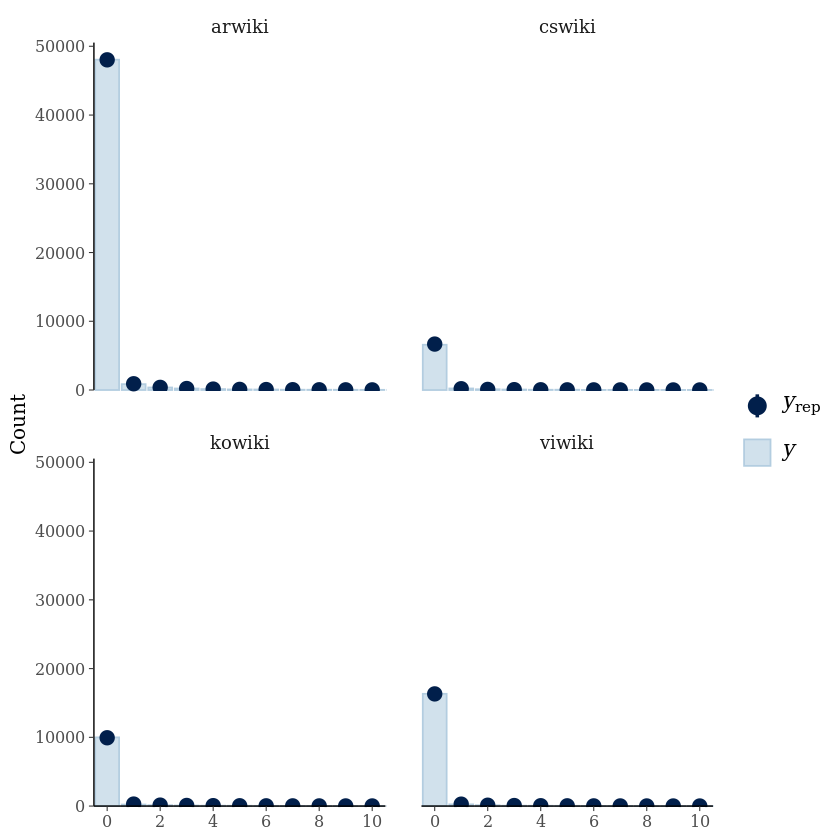

In [11]:
pp_check(nontagged_article_edits_2w.zinb.mod.2, 
         nsamples = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(0, 10))

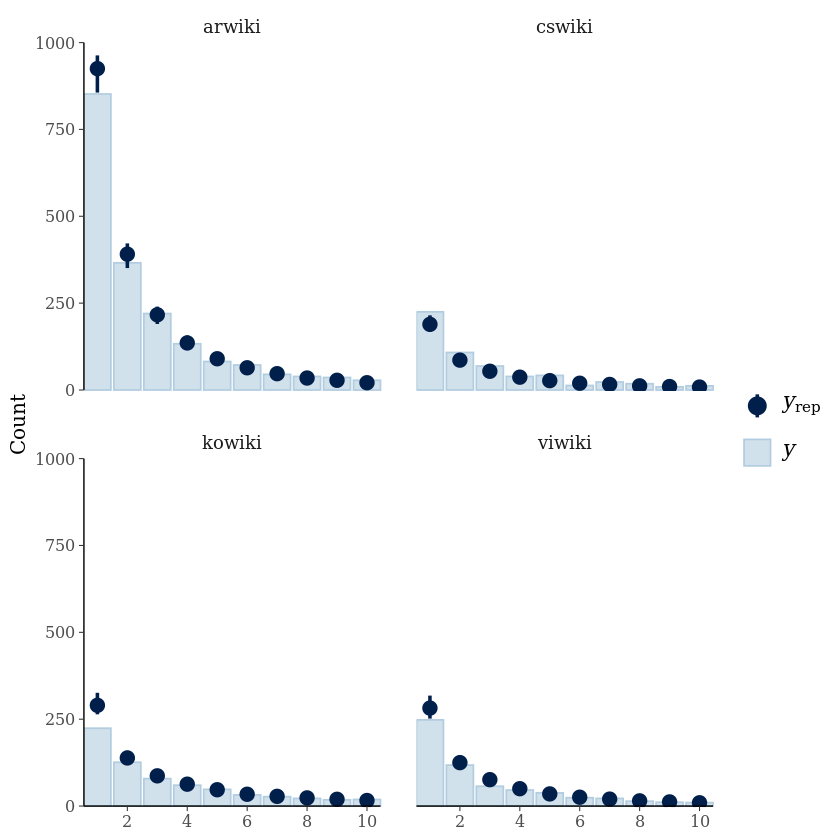

In [12]:
pp_check(nontagged_article_edits_2w.zinb.mod.2, 
         nsamples = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(1, 10), ylim = c(0, 1000))

In [ ]:
posterior_summary(nontagged_article_edits_2w.zinb.mod.2)

In [ ]:
draws <- posterior_samples(nontagged_article_edits_2w.zinb.mod.2)

In [ ]:
with(draws, {
    HP <- plogis(b_Intercept + b_is_treatment)
    Control <- plogis(b_Intercept)
    Diff = HP - Control
    c(
        c(HP = median(HP), Control = median(Control)), # group averages
        quantile(Diff, c(0.025, 0.5, 0.975)) # difference of HP - Control
    )
})

## Summary

We do not find a significant difference between the Control and Homepage groups in the number of Article & Article talk edits made in the two weeks following activation, when holding the number of edits made in the first 24 hours constant.

## Non-tagged Retention in Article and Article talk

In [29]:
ret.model.article.full = glmer(formula = is_retained_article ~ is_treatment + is_activated_article + 
                     log_num_article_edits_24hrs + reg_on_mobile + (1 | wiki_db),
                    family = binomial(link = "logit"), data = eligible_user_edit_data)

In [125]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(ret.model.article.full, c("theta", "fixef"))
ret.model.article.full = update(ret.model.article.full, start = start_vals,
                                control = glmerControl(optCtrl = list(maxfun = 2e4)))

In [30]:
summary(ret.model.article.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_retained_article ~ is_treatment + is_activated_article + log_num_article_edits_24hrs +  
    reg_on_mobile + (1 | wiki_db)
   Data: eligible_user_edit_data

     AIC      BIC   logLik deviance df.resid 
 13290.1  13346.2  -6639.1  13278.1    85229 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.166  0.000  0.000  0.000  3.318 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.003601 0.06001 
Number of obs: 85235, groups:  wiki_db, 4

Fixed effects:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -21.521382   1.740833 -12.363   <2e-16 ***
is_treatment                  0.002032   0.054909   0.037    0.970    
is_activated_articleTRUE     18.406886   1.741884  10.567   <2e-16 ***
log_num_article_edits_24hrs   1.169158   0.036150  32.342   <2e-16 ***
reg_on_mobile  

So we find similar results as before, that user retention is not dependent on the Homepage, but instead is dominated by the user's activity level early on.